In [1]:
#importamos las librerías necesarias
import pandas as pd
from urllib.request import urlopen
import urllib.request
import requests
import time 
from multiprocessing import Process, Queue, Pool
import threading
import sys
import re
import numpy as np
from datetime import date
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandasql as ps
from IPython.display import display,HTML
import matplotlib.pyplot as plt

In [2]:
def scrap_bellisima(producto): #definimos la función que recabará la información y la meterá en un dataframe
    
    """Permite obtener un dataframe con la siguiente información acerca de un producto:
        -Nombre
        -Precio a la venta
        -Precio anterior (si existe)
        -Marca
        -Fecha de consulta
        -Autoservicio donde se hace la consulta (en esta función en particular el sitio de donde se recabarán los datos es Bellísima).

    Args:
        producto (str)

    Returns:
        df_bellsima (dataframe)
    """
    
    path ="C:\webscraperlya\chromedriver.exe" #asignamos la ruta donde se encuentra el driver
    driver=webdriver.Chrome(path) #renombramos al driver
    producto = producto #introducimos el producto que queremos buscar en la variable producto
    #buscamos la url del sitio donde buscaremos la información, y en medio ponemos la variable producto
    url="https://bellisima.mx/search?type=product&options%5Bprefix%5D=last&options%5Bunavailable_products%5D=last&q="+producto+"&type=product&options%5Bprefix%5D=last&options%5Bunavailable_products%5D=last" 
    driver.get(url) #mediante el driver abrimos la url
    time.sleep(15) #dormimos el equipo para cargar la pagina
    productos=driver.find_elements_by_class_name("product-item.boost-pfs-action-list-enabled") #clase de los items mostrados
    #asignamos los nombres
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("product-item-meta__title")[0].text)
        except:
            lista_nombres.append(np.nan)
            
    #asignamos el precio de venta al público
    precio_1=[]
    for prod in productos:
        try:
            precio_1.append(prod.find_elements_by_class_name("price-list.price-list--centered")[0].text.split("\n")[1])
        except:
            precio_1.append(np.nan)
            
    #asignamos el precio anterior (si es que existe)        
    precio_2=[]
    for prod in productos:
        try:
            precio_2.append(prod.find_elements_by_class_name("price-list.price-list--centered")[0].text.split("\n")[3])
        except:
            precio_2.append(np.nan)
            
    #creamos el data frame
    df_bellisima =pd.DataFrame(columns=["NOMBRE","PRECIO_1","PRECIO_2","MARCA","FECHA","AUTOSERVICIO"])
    df_bellisima["NOMBRE"] = lista_nombres
    df_bellisima["PRECIO_1"] = precio_1
    df_bellisima["PRECIO_2"] = precio_2
    df_bellisima["MARCA"] = lista_nombres
    df_bellisima["FECHA"] = (date.today())
    df_bellisima["AUTOSERVICIO"] = "BELLÍSIMA"

    #separamos la información que no nos sirve del nombre del producto
    nuevo_nombre = []
    for i in df_bellisima.NOMBRE.str.split("-").tolist():
        try:
            nuevo_nombre.append(i[0])
        except:
            nuevo_nombre.append(np.nan)
            
    #asignamos la marca
    nueva_marca = []
    for i in df_bellisima.NOMBRE.str.split("-").tolist():
        try:
            nueva_marca.append(i[1])
        except:
            nueva_marca.append(np.nan)
    
    #actualizamos los datos en el dataframe
    df_bellisima["NOMBRE"] = nuevo_nombre
    df_bellisima["MARCA"] = nueva_marca
    
    #cerramos el driver
    driver.quit()
    
    #cambiamos el nombre del producto a mayúsculas
    prodd=producto.upper()
    
    #quitamos los elementos del dataframe que no tengan nada que ver con el producto que buscamos
    df_bellisima = df_bellisima[df_bellisima.NOMBRE.str.contains(prodd)]
    
    #limpiamos los precios del dataframe
    df_bellisima.PRECIO_1 =df_bellisima.PRECIO_1.str.replace("Desde","")
    df_bellisima.PRECIO_1 =df_bellisima.PRECIO_1.str.replace("$","")
    df_bellisima.PRECIO_1 =df_bellisima.PRECIO_1.str.replace(",","")
    df_bellisima.PRECIO_2 =df_bellisima.PRECIO_2.str.replace("$","")
    df_bellisima.PRECIO_2 =df_bellisima.PRECIO_2.str.replace(",","")
    
    #convertimos los precios a un dato numérico con decimales
    df_bellisima.PRECIO_1 = df_bellisima.PRECIO_1.astype(float)
    df_bellisima.PRECIO_2 = df_bellisima.PRECIO_2.astype(float)
    
    #regresamos el dataframe final
    return df_bellisima

In [3]:
def scrap_liverpool(producto): #definimos la función que recabará la información y la meterá en un dataframe
    
    """Permite obtener un dataframe con la siguiente información acerca de un producto:
        -Nombre
        -Precio a la venta
        -Precio anterior (si existe)
        -Marca
        -Fecha de consulta
        -Autoservicio donde se hace la consulta (en esta función en particular el sitio de donde se recabarán los datos es Liverpool).

    Args:
        producto (str)

    Returns:
        df_liverpool (dataframe)
    """
    
    path ="C:\webscraperlya\chromedriver.exe" #asignamos la ruta donde se encuentra el driver
    driver=webdriver.Chrome(path) #renombramos al driver
    producto = producto #introducimos el producto que queremos buscar en la variable producto
    url="https://www.liverpool.com.mx/tienda?s="+producto
    driver.get(url)
    time.sleep(12) #dormimos el equipo para cargar la pagina
    productos=driver.find_elements_by_class_name("m-product__card.card-masonry.a")  #clase de los items mostrados
    
    #asignamos los nombres
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("card-title.a-card-description")[0].text)
        except:
            lista_nombres.append(np.nan)
            
    #asignamos el precio promocion
    precio_1=[]
    for i in range(0,len(productos)):
        try:
            precio_1.append(productos[i].find_elements_by_class_name("a-card-discount")[0].text.replace("$",""))
        except:
            precio_1.append(np.nan)
            
   #asignamos el precio original
    precio_2=[]
    for i in range(0,len(productos)):
        try:
            precio_2.append(productos[i].find_elements_by_class_name("a-card-price")[0].text.replace("$",""))
        except:
            precio_2.append(np.nan)

    #creamos el data frame
    df_liverpool =pd.DataFrame(columns=["NOMBRE","PRECIO_1","PRECIO_2","MARCA","FECHA","AUTOSERVICIO"])
    df_liverpool["NOMBRE"] = lista_nombres
    df_liverpool["PRECIO_1"] = precio_1
    df_liverpool["PRECIO_2"]=precio_2
    df_liverpool["MARCA"]=lista_nombres
    df_liverpool["FECHA"] = (date.today())
    df_liverpool["AUTOSERVICIO"] = "LIVERPOOL"
    
    #cerramos el driver
    driver.quit()
    
    nuevo_precio_1= []
    for i in df_liverpool.PRECIO_1.str.split(" -").tolist():
        try:
            nuevo_precio_1.append((i[0])[:-2])
        except:
            pass
        
    nuevo_precio_2= []
    for i in df_liverpool.PRECIO_2.str.split(" -").tolist():
        try:
            nuevo_precio_2.append((i[0])[:-2])
        except:
            nuevo_precio_2.append(np.nan)
            
    #asignamos la marca    
    nueva_marca = []
    for i in df_liverpool.MARCA.str.split(" ").tolist():
        try:
            nueva_marca.append(i[1])
        except:
            pass
           
    df_liverpool["PRECIO_1"]=nuevo_precio_1
    df_liverpool["PRECIO_2"]=nuevo_precio_2
    df_liverpool.PRECIO_1 =df_liverpool.PRECIO_1.str.replace(",","")
    try:
        df_liverpool.PRECIO_2 =df_liverpool.PRECIO_2.str.replace(",","")
    except:
        pass
    df_liverpool.MARCA=nueva_marca
    
    driver.quit()
    
    df_liverpool.PRECIO_1 = df_liverpool.PRECIO_1.astype(float)
    df_liverpool.PRECIO_2 = df_liverpool.PRECIO_2.astype(float)
    df_liverpool.MARCA = df_liverpool.MARCA.replace("de","SM")
    df_liverpool.NOMBRE=df_liverpool.NOMBRE.str.upper()
    df_liverpool.MARCA=df_liverpool.MARCA.str.upper()
     
    prodd=producto.upper()
    
    df_liverpool = df_liverpool[df_liverpool.NOMBRE.str.contains(prodd)]
            
    return df_liverpool

In [4]:
def scrap_vorana(producto): #definimos la función que recabará la información y la meterá en un dataframe
    
    """Permite obtener un dataframe con la siguiente información acerca de un producto:
        -Nombre
        -Precio a la venta
        -Precio anterior (si existe)
        -Marca
        -Fecha de consulta
        -Autoservicio donde se hace la consulta (en esta función en particular el sitio de donde se recabarán los datos es Vorana).

    Args:
        producto (str)

    Returns:
        df_vorana (dataframe)
    """
    
    path ="C:\webscraperlya\chromedriver.exe" #asignamos la ruta donde se encuentra el driver
    driver=webdriver.Chrome(path) #renombramos al driver
    producto = producto #introducimos el producto que queremos buscar en la variable producto
    url="https://www.vorana.mx/search?q="+producto
    driver.get(url)
    time.sleep(12)
    productos=driver.find_elements_by_class_name("card")  #clase de los items mostrados
    
    productos.pop(0)
    productos.pop(0)
    productos.pop(0)
    
    #asignamos nombres
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("title")[0].text)
        except:
            lista_nombres.append(np.nan)
   #asignamos el precio original
    precio_1=[]
    for prod in productos:
        try:
            precio_1.append(prod.find_elements_by_class_name("controls")[0].text.split("\n")[0])
        except:
            precio_1.append(np.nan)
    #asignamos la marca        
    marca=[]
    for prod in productos:
        try:
            marca.append(prod.find_elements_by_class_name("collection")[0].text)
        except:
            marca.append(np.nan)

    driver.quit()
    #creamos el data frame
    df_vorana =pd.DataFrame(columns=["NOMBRE","PRECIO_1","PRECIO_2","MARCA","FECHA","AUTOSERVICIO"])
    df_vorana["NOMBRE"] = lista_nombres
    df_vorana["PRECIO_1"] = precio_1
    df_vorana["PRECIO_2"] = np.nan
    df_vorana["MARCA"] = marca
    df_vorana["FECHA"] = (date.today())
    df_vorana["AUTOSERVICIO"] = "VORANA"
    
    df_vorana.PRECIO_1 =df_vorana.PRECIO_1.str.replace(",","")
    df_vorana.NOMBRE=df_vorana.NOMBRE.str.upper()
    df_vorana.PRECIO_1 = df_vorana.PRECIO_1.astype(float)
    
    return df_vorana
    

In [5]:
#asignamos los productos que queremos buscar a distintas variables

Producto_1="labial"
Producto_2="sombras"
Producto_3="rubor"
Producto_4="corrector"
Producto_5="brocha"

In [6]:
#asignamos el dataframe de cada producto a una variable

df_be1=scrap_bellisima(Producto_1)
df_be2=scrap_bellisima(Producto_2)
df_be3=scrap_bellisima(Producto_3)
df_be4=scrap_bellisima(Producto_4)
df_be5=scrap_bellisima(Producto_5)

C:\Users\Lupita\AppData\Local\Temp\ipykernel_11396\1621553808.py:90: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_bellisima.PRECIO_1 =df_bellisima.PRECIO_1.str.replace("$","")
C:\Users\Lupita\AppData\Local\Temp\ipykernel_11396\1621553808.py:92: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_bellisima.PRECIO_2 =df_bellisima.PRECIO_2.str.replace("$","")
C:\Users\Lupita\AppData\Local\Temp\ipykernel_11396\1621553808.py:90: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_bellisima.PRECIO_1 =df_bellisima.PRECIO_1.str.re

In [7]:
#concatenamos todos los dataframe del primer sitio en uno solo
df_bellisimaneto=pd.concat([df_be1,df_be2,df_be3,df_be4,df_be5])

#reseteamos los índices del dataframe de Bellísima
df_bellisimaneto.reset_index(drop=True, inplace=True)

In [8]:
#convertimos el dataframe en un archivo .csv para poder comprobar en un formato visual más agradable que se creó correctamente
df_bellisimaneto.to_csv("Bellísima_completo.csv")

In [9]:
#asignamos el dataframe de cada producto a una variable

df_liv1=scrap_liverpool(Producto_1)
df_liv2=scrap_liverpool(Producto_2)
df_liv3=scrap_liverpool(Producto_3)
df_liv4=scrap_liverpool(Producto_4)
df_liv5=scrap_liverpool(Producto_5)

In [10]:
#concatenamos todos los dataframe del primer sitio en uno solo
df_liverpoolneto=pd.concat([df_liv1,df_liv2,df_liv3,df_liv4,df_liv5])

#reseteamos los índices del dataframe de Liverpool
df_liverpoolneto.reset_index(drop=True, inplace=True)

In [11]:
#convertimos el dataframe en un archivo .csv para poder comprobar en un formato visual más agradable que se creó correctamente
df_liverpoolneto.to_csv("Liverpool_completo.csv")

In [12]:
#asignamos el dataframe de cada producto a una variable

df_vor1=scrap_vorana(Producto_1)
df_vor2=scrap_vorana(Producto_2)
df_vor3=scrap_vorana(Producto_3)
df_vor4=scrap_vorana(Producto_4)
df_vor5=scrap_vorana(Producto_5)

In [13]:
#concatenamos todos los dataframe del primer sitio en uno solo
df_vorananeto=pd.concat([df_vor1,df_vor2,df_vor3,df_vor4,df_vor5])

#reseteamos los índices del dataframe de Liverpool
df_vorananeto.reset_index(drop=True, inplace=True)

In [14]:
#convertimos el dataframe en un archivo .csv para poder comprobar en un formato visual más agradable que se creó correctamente
df_vorananeto.to_csv("Vorana_completo.csv")

In [15]:
#en un solo dataframe concatenamos el dataframe de los tres sitios
df_final=pd.concat([df_bellisimaneto,df_liverpoolneto,df_vorananeto])

#reseteamos los índices
df_final.reset_index(drop=True, inplace=True)

In [16]:
#creamos un archivo .csv con la base de datos final
df_final.to_csv("Datos_final.csv")

In [17]:
#CONSULTAS
#buscamos todas las distintas marcas que manejamos en la base de datos
ps.sqldf("select distinct MARCA from df_final")

,MARCA
0,LIP SMACKER
1,BISSÚ
2,REVLON
3,OUTLET BISSÚ
4,ESSENCE
...,...
102,PRACTK® BY SIGMA BEAUTY®
103,EYE KANDY
104,LILLY LASHES
105,BEAUTYBLENDER


In [18]:
#ordenamos todos los productos por su precio de venta al público de mayor a menor
ps.sqldf("select * from df_final order by PRECIO_1 desc")

,NOMBRE,PRECIO_1,PRECIO_2,MARCA,FECHA,AUTOSERVICIO
0,RUBOR SISLEY L'ORQUIDEE,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL
1,RUBOR SISLEY L'ORCHIDÉE CORAIL,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL
2,RUBOR SISLEY PHYTO TOUCHE SUN GLOW POWDER PEAC...,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL
3,CORRECTOR SISLEY PHYTO CERNES ECLAT,2700.00,NaN,SISLEY,2022-12-09,LIVERPOOL
4,BROCHA LA MER,2150.00,NaN,LA,2022-12-09,LIVERPOOL
...,...,...,...,...,...,...
703,LABIAL HUMECTANTE,30.24,36.0,BISSÚ,2022-12-09,BELLÍSIMA
704,LABIAL MATE,27.30,39.0,OUTLET BISSÚ,2022-12-09,BELLÍSIMA
705,BASICS SOMBRAS INDIVIDUALES,27.30,39.0,OUTLET LURE,2022-12-09,BELLÍSIMA
706,CORRECTOR,24.00,29.0,BISSÚ,2022-12-09,BELLÍSIMA


In [19]:
#buscamos todos los productos que cuestan más de $1000
ps.sqldf("select * from df_final where PRECIO_1>1000")

,NOMBRE,PRECIO_1,PRECIO_2,MARCA,FECHA,AUTOSERVICIO
0,SET LABIAL MATE BISSÚ,1900.0,None,LABIAL,2022-12-09,LIVERPOOL
1,SET LABIAL HUMECTANTE BISSÚ COLECCIÓN COMPLETA,1900.0,None,LABIAL,2022-12-09,LIVERPOOL
2,PALETA DE SOMBRAS URBAN DECAY NAKED X ROBIN EI...,1280.0,None,SM,2022-12-09,LIVERPOOL
3,SOMBRAS CHANEL LES 4 OMBRES,1250.0,None,CHANEL,2022-12-09,LIVERPOOL
4,SOMBRAS CHANEL LES BEIGE,1380.0,None,CHANEL,2022-12-09,LIVERPOOL
5,PALETA DE SOMBRAS BIANCA MAKEUP,1295.0,None,SM,2022-12-09,LIVERPOOL
6,RUBOR M.A.C BUBBLES & BOWS,1399.0,None,M.A.C,2022-12-09,LIVERPOOL
7,RUBOR M.A.C BUBBLES & BOWS,1399.0,None,M.A.C,2022-12-09,LIVERPOOL
8,CHANEL\nPINCEAU BLUSH N°110\nPINCEL PARA RUBOR,1380.0,None,BLUSH,2022-12-09,LIVERPOOL
9,RUBOR SISLEY L'ORQUIDEE,2800.0,None,SISLEY,2022-12-09,LIVERPOOL


In [20]:
#buscamos los productos que cuestan menos de $100
ps.sqldf("select * from df_final where PRECIO_1<100")

,NOMBRE,PRECIO_1,PRECIO_2,MARCA,FECHA,AUTOSERVICIO
0,LABIAL HUMECTANTE,30.24,36.0,BISSÚ,2022-12-09,BELLÍSIMA
1,BRILLO LABIAL,41.00,49.0,BISSÚ,2022-12-09,BELLÍSIMA
2,LABIAL HUMECTANTE,18.48,22.0,BISSÚ,2022-12-09,BELLÍSIMA
3,LABIAL MATE,38.64,46.0,BISSÚ,2022-12-09,BELLÍSIMA
4,LABIAL MATE,27.30,39.0,OUTLET BISSÚ,2022-12-09,BELLÍSIMA
5,LABIAL HIDRATANTE NUDE,60.20,86.0,ESSENCE,2022-12-09,BELLÍSIMA
6,LABIAL TINTA MATE,78.96,94.0,BISSÚ,2022-12-09,BELLÍSIMA
7,SPRITE BÁLSAMOS LABIAL SPRITE,39.20,49.0,LIP SMACKER,2022-12-09,BELLÍSIMA
8,PRISMA GLAZE GLOSS LABIAL 080,83.00,99.0,CATRICE,2022-12-09,BELLÍSIMA
9,BERRY ON MATTE LABIAL LÍQUIDO,55.30,79.0,OUTLET ESSENCE,2022-12-09,BELLÍSIMA


In [21]:
#buscamos los productos de Bellísima que tienen rebaja
ps.sqldf("select NOMBRE from df_final where PRECIO_2 is not null and AUTOSERVICIO='BELLÍSIMA'")

,NOMBRE
0,COCA COLA BÁLSAMO LABIAL
1,SUGAR BEAR GRAPEFUL 4 U BÁLSAMO LABIAL
2,LABIAL HUMECTANTE
3,BRILLO LABIAL
4,LABIAL HUMECTANTE
...,...
87,SHAMPOO PARA LIMPIAR BROCHAS Y ESPONJAS
88,BROCHA Y CEPILLO PARA PESTAÑAS Y CEJAS
89,BROCHAS DE SILICONA PARA MASCARILLAS FACIALES
90,TRIO DE BROCHAS PARA OJOS LAVISH COLLECTION


In [22]:
#buscamos las distintas marcas de correctores que maneja Liverpool
ps.sqldf("select distinct MARCA from df_final where PRECIO_1<200 and NOMBRE like '%CORRECTOR%' and AUTOSERVICIO='LIVERPOOL'")

,MARCA
0,NYX
1,LÍQUIDO
2,MAYBELLINE
3,DIVYA
4,LOREAL
5,GOT


In [23]:
#obtenemos el promedio de precios que maneja la marca Bissú
ps.sqldf("select avg(PRECIO_1) as 'Promedio de precios de Bissú' from df_final where MARCA like'%BISSÚ%'")

,Promedio de precios de Bissú
0,123.106154


In [24]:
#buscamos los productos de la marca Sisley que cuestan más de $100
ps.sqldf("select * from df_final where MARCA like'%SISLEY%' and PRECIO_1>100")

,NOMBRE,PRECIO_1,PRECIO_2,MARCA,FECHA,AUTOSERVICIO
0,RUBOR SISLEY L'ORQUIDEE,2800.0,None,SISLEY,2022-12-09,LIVERPOOL
1,RUBOR SISLEY L'ORCHIDÉE CORAIL,2800.0,None,SISLEY,2022-12-09,LIVERPOOL
2,RUBOR SISLEY PHYTO TWIST FUSHIA,1700.0,None,SISLEY,2022-12-09,LIVERPOOL
3,RUBOR SISLEY PHYTO TWIST PETAL,1700.0,None,SISLEY,2022-12-09,LIVERPOOL
4,RUBOR SISLEY LE PHYTO,1950.0,None,SISLEY,2022-12-09,LIVERPOOL
5,RUBOR SISLEY PHYTO BLUSH TWIST,1700.0,None,SISLEY,2022-12-09,LIVERPOOL
6,RUBOR SISLEY PHYTO-BLUSH TWIST,1700.0,None,SISLEY,2022-12-09,LIVERPOOL
7,RUBOR SISLEY PHYTO TOUCHE SUN GLOW POWDER PEAC...,2800.0,None,SISLEY,2022-12-09,LIVERPOOL
8,CORRECTOR SISLEY PHYTO CERNES ECLAT,2700.0,None,SISLEY,2022-12-09,LIVERPOOL


In [25]:
#buscamos todos los rubores que son de la marca Bissú o Sisley
ps.sqldf("select * from df_final where NOMBRE like'%RUBOR%' and (MARCA like'%BISSÚ%' or MARCA like '%SISLEY%')")

,NOMBRE,PRECIO_1,PRECIO_2,MARCA,FECHA,AUTOSERVICIO
0,RUBOR PROFESIONAL,42.84,51.0,BISSÚ,2022-12-09,BELLÍSIMA
1,RUBOR SISLEY L'ORQUIDEE,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL
2,RUBOR SISLEY L'ORCHIDÉE CORAIL,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL
3,RUBOR SISLEY PHYTO TWIST FUSHIA,1700.00,NaN,SISLEY,2022-12-09,LIVERPOOL
4,RUBOR SISLEY PHYTO TWIST PETAL,1700.00,NaN,SISLEY,2022-12-09,LIVERPOOL
5,RUBOR SISLEY LE PHYTO,1950.00,NaN,SISLEY,2022-12-09,LIVERPOOL
6,RUBOR SISLEY PHYTO BLUSH TWIST,1700.00,NaN,SISLEY,2022-12-09,LIVERPOOL
7,RUBOR SISLEY PHYTO-BLUSH TWIST,1700.00,NaN,SISLEY,2022-12-09,LIVERPOOL
8,RUBOR SISLEY PHYTO TOUCHE SUN GLOW POWDER PEAC...,2800.00,NaN,SISLEY,2022-12-09,LIVERPOOL


In [26]:
#obtenemos el promedio de precios de los labiales por cada sitio y los metemos en dataframes
prom_lab_be=ps.sqldf("select avg(PRECIO_1) as 'Labial' from df_final where NOMBRE like'%LABIAL%' and AUTOSERVICIO like'%BELLÍSIMA%'")
prom_lab_liv=ps.sqldf("select avg(PRECIO_1) as 'Labial' from df_final where NOMBRE like'%LABIAL%' and AUTOSERVICIO like'%LIVERPOOL%'")
prom_lab_vo=ps.sqldf("select avg(PRECIO_1) as 'Labial' from df_final where NOMBRE like'%LIP%' and AUTOSERVICIO like'%VORANA%'")

In [27]:
#concatenamos los dataframes para crear un dataframe de promedios de labiales y resetamos el índice
promedios_labiales=pd.concat([prom_lab_be,prom_lab_liv,prom_lab_vo])
promedios_labiales.reset_index(drop=True, inplace=True)

In [28]:
#obtenemos el promedio de precios de las sombras por cada sitio y los metemos en dataframes
prom_som_be=ps.sqldf("select avg(PRECIO_1) as 'Sombras' from df_final where NOMBRE like'%SOMBRAS%' and AUTOSERVICIO like'%BELLÍSIMA%'")
prom_som_liv=ps.sqldf("select avg(PRECIO_1) as 'Sombras' from df_final where NOMBRE like'%SOMBRAS%' and AUTOSERVICIO like'%LIVERPOOL%'")
prom_som_vo=ps.sqldf("select avg(PRECIO_1) as 'Sombras' from df_final where NOMBRE like'%EYE%' and AUTOSERVICIO like'%VORANA%'")

In [29]:
#concatenamos los dataframes para crear un dataframe de promedios de sombras y resetamos el índice
promedios_sombras=pd.concat([prom_som_be,prom_som_liv,prom_som_vo])
promedios_sombras.reset_index(drop=True, inplace=True)

In [30]:
#obtenemos el promedio de precios de los rubores por cada sitio y los metemos en dataframes
prom_rub_be=ps.sqldf("select avg(PRECIO_1) as 'Rubor' from df_final where NOMBRE like'%RUBOR%' and AUTOSERVICIO like'%BELLÍSIMA%'")
prom_rub_liv=ps.sqldf("select avg(PRECIO_1) as 'Rubor' from df_final where NOMBRE like'%RUBOR%' and AUTOSERVICIO like'%LIVERPOOL%'")
prom_rub_vo=ps.sqldf("select avg(PRECIO_1) as 'Rubor' from df_final where NOMBRE like'%BLUSH%' and AUTOSERVICIO like'%VORANA%'")

In [31]:
#concatenamos los dataframes para crear un dataframe de promedios de rubores y resetamos el índice
promedios_rubor=pd.concat([prom_rub_be,prom_rub_liv,prom_rub_vo])
promedios_rubor.reset_index(drop=True, inplace=True)

In [32]:
#obtenemos el promedio de precios de los correctores por cada sitio y los metemos en dataframes
prom_cor_be=ps.sqldf("select avg(PRECIO_1) as 'Corrector' from df_final where NOMBRE like'%CORREC%' and AUTOSERVICIO like'%BELLÍSIMA%'")
prom_cor_liv=ps.sqldf("select avg(PRECIO_1) as 'Corrector' from df_final where NOMBRE like'%CORREC%' and AUTOSERVICIO like'%LIVERPOOL%'")
prom_cor_vo=ps.sqldf("select avg(PRECIO_1) as 'Corrector' from df_final where NOMBRE like'%CONCEALER%' and AUTOSERVICIO like'%VORANA%'")

In [33]:
#concatenamos los dataframes para crear un dataframe de promedios de correctores y resetamos el índice
promedios_corrector=pd.concat([prom_cor_be,prom_cor_liv,prom_cor_vo])
promedios_corrector.reset_index(drop=True, inplace=True)

In [34]:
#obtenemos el promedio de precios de las brochas por cada sitio y los metemos en dataframes
prom_bro_be=ps.sqldf("select avg(PRECIO_1) as 'Brochas' from df_final where NOMBRE like'%BROCH%' and AUTOSERVICIO like'%BELLÍSIMA%'")
prom_bro_liv=ps.sqldf("select avg(PRECIO_1) as 'Brochas' from df_final where NOMBRE like'%BROCH%' and AUTOSERVICIO like'%LIVERPOOL%'")
prom_bro_vo=ps.sqldf("select avg(PRECIO_1) as 'Brochas' from df_final where NOMBRE like'%BRUSH%' and AUTOSERVICIO like'%VORANA%'")

In [35]:
#concatenamos los dataframes para crear un dataframe de promedios de brochas y resetamos el índice
promedios_brochas=pd.concat([prom_bro_be,prom_bro_liv,prom_bro_vo])
promedios_brochas.reset_index(drop=True, inplace=True)

In [36]:
#creamos un dataframe donde ubicaremos los promedios de precios por autoservicio y producto
df_promedios =pd.DataFrame(columns=["AUTOSERVICIO","LABIAL","SOMBRAS","RUBOR","CORRECTOR","BROCHAS"])
df_promedios["AUTOSERVICIO"]=["BELLÍSIMA","LIVERPOOL","VORANA"]
df_promedios["LABIAL"]=promedios_labiales
df_promedios["SOMBRAS"]=promedios_sombras
df_promedios["RUBOR"]=promedios_rubor
df_promedios["CORRECTOR"]=promedios_corrector
df_promedios["BROCHAS"]=promedios_brochas

In [37]:
df_promedios

,AUTOSERVICIO,LABIAL,SOMBRAS,RUBOR,CORRECTOR,BROCHAS
0,BELLÍSIMA,123.849000,359.179000,217.964286,180.255789,185.736190
1,LIVERPOOL,485.839286,605.291667,923.106383,566.017857,684.750000
2,VORANA,438.777778,433.242424,463.285714,359.095238,356.733333


<AxesSubplot:title={'center':'Promedio de precios por página de labiales'}, xlabel='AUTOSERVICIO'>

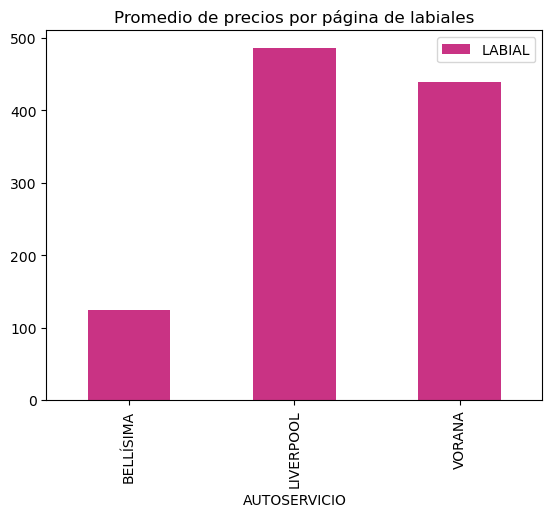

In [38]:
#GRÁFICAS
#creamos una gráfica de promedio de precios por cada sitio de los labiales
df_promedios.plot(x="AUTOSERVICIO", y="LABIAL", kind="bar", stacked=False, title="Promedio de precios por página de labiales", color="#c93384")

<AxesSubplot:title={'center':'Promedio de precios por página de las sombras'}, xlabel='AUTOSERVICIO'>

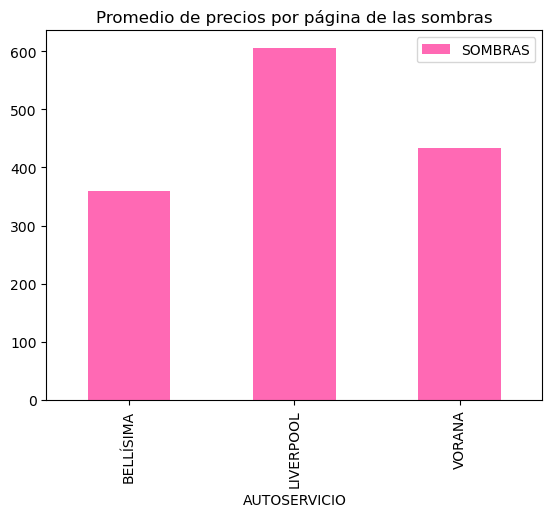

In [39]:
#creamos una gráfica de promedio de precios por cada sitio de las sombras
df_promedios.plot(x="AUTOSERVICIO", y="SOMBRAS", kind="bar", stacked=False, title="Promedio de precios por página de las sombras", color="#ff69b4")

<AxesSubplot:title={'center':'Promedio de precios por página de los rubores'}, xlabel='AUTOSERVICIO'>

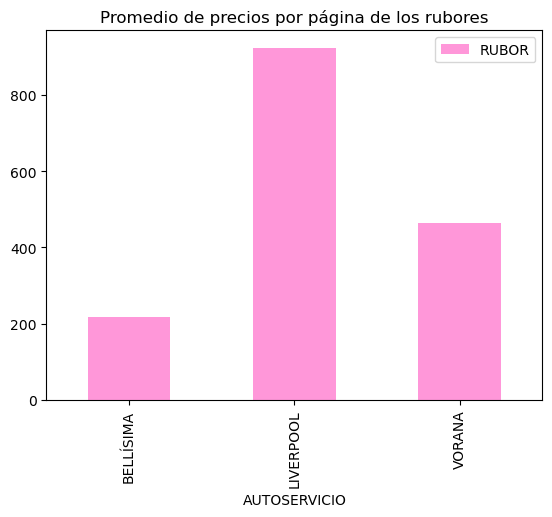

In [40]:
#creamos una gráfica de promedio de precios por cada sitio de los rubores
df_promedios.plot(x="AUTOSERVICIO", y="RUBOR", kind="bar", stacked=False, title="Promedio de precios por página de los rubores", color="#ff97d9")

<AxesSubplot:title={'center':'Promedio de precios por página de los correctores'}, xlabel='AUTOSERVICIO'>

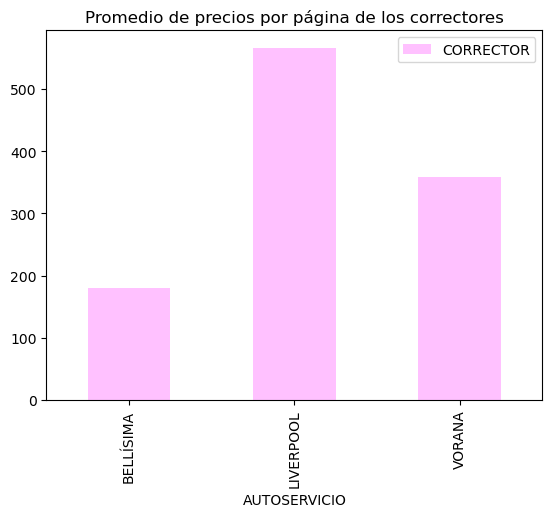

In [41]:
#creamos una gráfica de promedio de precios por cada sitio de los correctores
df_promedios.plot(x="AUTOSERVICIO", y="CORRECTOR", kind="bar", stacked=False, title="Promedio de precios por página de los correctores", color="#ffc1ff")

<AxesSubplot:title={'center':'Promedio de precios por página de las brochas'}, xlabel='AUTOSERVICIO'>

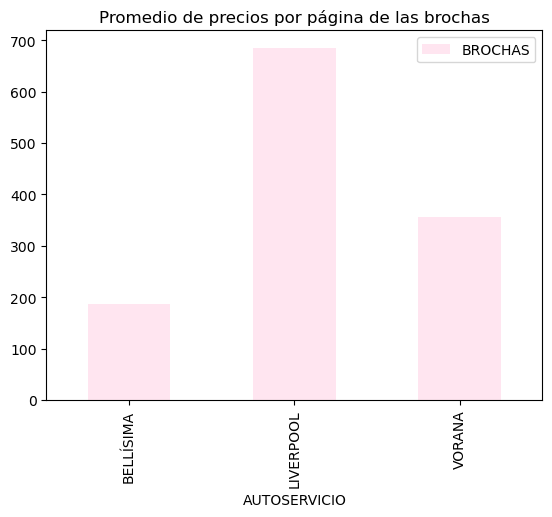

In [42]:
#creamos una gráfica de promedio de precios por cada sitio de las brochas
df_promedios.plot(x="AUTOSERVICIO", y="BROCHAS", kind="bar", stacked=False, title="Promedio de precios por página de las brochas", color="#ffe5f0")

<AxesSubplot:title={'center':'Promedio de precios por página'}, xlabel='AUTOSERVICIO'>

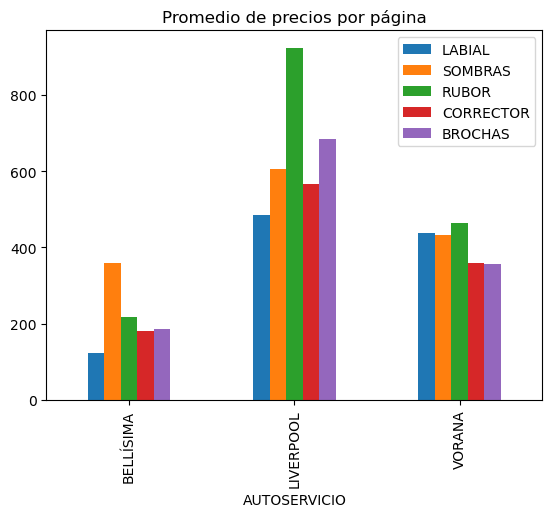

In [43]:
#creamos una gráfica de promedio de precios por cada sitio de todos los productos
df_promedios.plot(x="AUTOSERVICIO", kind="bar", stacked=False, title="Promedio de precios por página")